In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import re
import string
import nltk

%matplotlib inline

In [2]:
train = pd.read_csv("C:\\Users\\sidar\\Downloads\\DisasterTweets\\train.csv")
test = pd.read_csv("C:\\Users\\sidar\\Downloads\\DisasterTweets\\test.csv")

In [3]:
X_train = train.drop(['target'], axis=1)
y_train = train['target']
y = y_train

### Finding the number of train and test data points

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


### Finding the number of tweets that are actually about real disasters.

In [6]:
percentage_real = (train['target'].sum() / train['target'].count()) * 100
percentage_real

42.96597924602653

Which implies that the number of tweets that aren't about real disasters is 57.034.

# Preprocessing

In [7]:
X_train.head()

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


In [8]:
X = pd.DataFrame(X_train["id"])
X = pd.concat([X, X_train["keyword"].str.lower()], axis=1)
X = pd.concat([X, X_train["location"].str.lower()], axis=1)
X = pd.concat([X, X_train["text"].str.lower()], axis=1)

t = pd.DataFrame(test["id"])
t = pd.concat([t, test["keyword"].str.lower()], axis=1)
t = pd.concat([t, test["location"].str.lower()], axis=1)
t = pd.concat([t, test["text"].str.lower()], axis=1)

In [9]:
def drop_url(t):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',t)

X['text'] = X['text'].apply(lambda x : drop_url(x))
t['text'] = t['text'].apply(lambda x : drop_url(x))

In [10]:
def drop_mentions(t):
    url = re.compile(r'@\S+')
    return url.sub(r'',t)

X['text'] = X['text'].apply(lambda x : drop_mentions(x))
t['text'] = t['text'].apply(lambda x : drop_mentions(x))

In [11]:
def punctuation(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

X['text'] = X['text'].apply(lambda x : punctuation(x))
t['text'] = t['text'].apply(lambda x : punctuation(x))

In [12]:
#X_train["text"] = X_train["text"].str.split()
X.head(20)

,id,keyword,location,text
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to shelter in place are be...
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...
5,8,NaN,NaN,rockyfire update california hwy 20 closed in ...
6,10,NaN,NaN,flood disaster heavy rain causes flash floodin...
7,13,NaN,NaN,im on top of the hill and i can see a fire in ...
8,14,NaN,NaN,theres an emergency evacuation happening now i...
9,15,NaN,NaN,im afraid that the tornado is coming to our area


Next, we stem the words to increase the uniformity and make sure that tense and related conjugations don't confuse the algorithm.

In [13]:
lemmatizer = nltk.stem.PorterStemmer()
for x in X["text"]:
    x = lemmatizer.stem(x)

In [14]:
for x in t["text"]:
    x = lemmatizer.stem(x)

In [15]:
for a in X['keyword']:
    if a is None:
        a = ""
for a in t['keyword']:
    if a is None:
        a = ""
t.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan


In [16]:
X['keyword'] = X['keyword'].apply(lambda b: str(b).replace('%20', ' '))
t['keyword'] = t['keyword'].apply(lambda b: str(b).replace('%20', ' '))

X.head(20)

,id,keyword,location,text
0,1,nan,NaN,our deeds are the reason of this earthquake ma...
1,4,nan,NaN,forest fire near la ronge sask canada
2,5,nan,NaN,all residents asked to shelter in place are be...
3,6,nan,NaN,13000 people receive wildfires evacuation orde...
4,7,nan,NaN,just got sent this photo from ruby alaska as s...
5,8,nan,NaN,rockyfire update california hwy 20 closed in ...
6,10,nan,NaN,flood disaster heavy rain causes flash floodin...
7,13,nan,NaN,im on top of the hill and i can see a fire in ...
8,14,nan,NaN,theres an emergency evacuation happening now i...
9,15,nan,NaN,im afraid that the tornado is coming to our area


In [17]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
X['text'] = X['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
t['text'] = t['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [18]:
t.head(20)

,id,keyword,location,text
0,0,nan,NaN,happened terrible car crash
1,2,nan,NaN,heard earthquake different cities stay safe ev...
2,3,nan,NaN,forest fire spot pond geese fleeing across str...
3,9,nan,NaN,apocalypse lighting spokane wildfires
4,11,nan,NaN,typhoon soudelor kills 28 china taiwan
5,12,nan,NaN,shakingits earthquake
6,21,nan,NaN,theyd probably still show life arsenal yesterd...
7,22,nan,NaN,hey
8,27,nan,NaN,nice hat
9,29,nan,NaN,fuck


In [19]:
X['text'] = X.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
t['text'] = t.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [20]:
t.head()

,id,keyword,location,text
0,0,nan,NaN,"[happened, terrible, car, crash]"
1,2,nan,NaN,"[heard, earthquake, different, cities, stay, s..."
2,3,nan,NaN,"[forest, fire, spot, pond, geese, fleeing, acr..."
3,9,nan,NaN,"[apocalypse, lighting, spokane, wildfires]"
4,11,nan,NaN,"[typhoon, soudelor, kills, 28, china, taiwan]"


### Splitting Training and Dev sets

In [21]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y_train, test_size=0.33, random_state=42)

# Bag of Words Model 

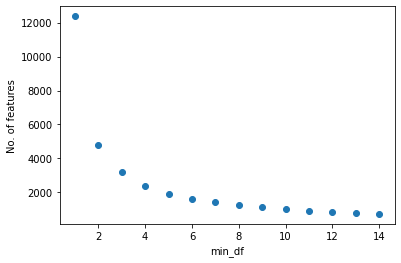

In [22]:
def dummy(doc):
    return doc

data = []
for i in range(1,15):
    cVect= CountVectorizer(min_df=i, binary=True, tokenizer=dummy, preprocessor=dummy)
    tFit = cVect.fit_transform(X_train['text'])
    data.append(tFit.shape[1])
    
plt.scatter(list(range(1,15)), data)
plt.xlabel('min_df')
plt.ylabel('No. of features')
plt.show()

Taking min_df to be 6 since the elbow seems to occur at that point, which should be a good compromise between maintaining sensitivity to keywords while reducing the feature space appreciably.

In [23]:
cv = CountVectorizer(min_df=6, binary=True, tokenizer=dummy, preprocessor=dummy)  

In [24]:
X_train_cv = cv.fit_transform(X_train['text'])

In [25]:
cv.vocabulary_

{'photo': 1056,
 'around': 123,
 'rubble': 1191,
 'end': 475,
 'man': 879,
 'crush': 359,
 'everyday': 496,
 'yes': 1611,
 'feel': 542,
 'root': 1186,
 'shame': 1263,
 'found': 580,
 'trauma': 1452,
 'everyone': 497,
 'would': 1595,
 'join': 785,
 'isis': 768,
 'get': 612,
 'trying': 1470,
 'detonate': 408,
 'hot': 718,
 'dogs': 428,
 'fort': 579,
 'potus': 1088,
 'strategy': 1353,
 'genocide': 609,
 'refugees': 1144,
 'internally': 758,
 'displaced': 424,
 'people': 1049,
 'horror': 713,
 'etc': 487,
 'stream': 1354,
 'hurricane': 728,
 'reddits': 1143,
 'new': 977,
 'content': 331,
 'policy': 1079,
 'goes': 627,
 'effect': 465,
 'many': 882,
 'horrible': 712,
 'subreddits': 1365,
 'banned': 159,
 'quarantined': 1112,
 'god': 625,
 'right': 1171,
 'love': 865,
 'obliterated': 998,
 'ball': 156,
 'fuck': 590,
 'box': 219,
 'flames': 560,
 'upon': 1495,
 'bioterrorism': 186,
 '2': 19,
 '4': 33,
 'ends': 477,
 'mass': 887,
 'murder': 955,
 'loud': 863,
 'ass': 133,
 'thunder': 1421,
 'wa

In [26]:
cv_dev = CountVectorizer(binary=True, vocabulary=cv.get_feature_names(), tokenizer=dummy, preprocessor=dummy)
X_dev_cv = cv_dev.fit_transform(X_dev['text'])

# Logistic Regression

## No regularization

### Training set

In [27]:
logreg_N = LogisticRegression(penalty='none', max_iter=3600, solver='saga')
logreg_N.fit(X_train_cv, y_train)

LogisticRegression(max_iter=3600, penalty='none', solver='saga')

In [28]:
preds_N_train = logreg_N.predict(X_train_cv)
f1_N_train = f1_score(y_train, preds_N_train)
print(f1_N_train)

0.9221556886227544


### Dev set

In [29]:
preds_N_dev = logreg_N.predict(X_dev_cv)
f1_N_dev = f1_score(y_dev, preds_N_dev)
print(f1_N_dev)

0.6929347826086957


This is a textbook example of overfitting, which should be remedied to some extent by regularization.

## L1 regularization

In [30]:
logreg_l1 = LogisticRegression(solver='saga', penalty='l1', max_iter=600)
logreg_l1.fit(X_train_cv, y_train)

LogisticRegression(max_iter=600, penalty='l1', solver='saga')

### Training set

In [31]:
preds_l1_train = logreg_l1.predict(X_train_cv)
f1_l1_train = f1_score(y_train, preds_l1_train)
print(f1_l1_train)

0.8313840155945419


### Dev set

In [32]:
preds_l1_dev = logreg_l1.predict(X_dev_cv)
f1_l1_dev = f1_score(y_dev, preds_l1_dev)
print(f1_l1_dev)

0.7342026078234702


There is an improvement with L1 regularization, in that the model does not seem to be overfitting the training data as badly as it was, and the dev set accuracy is higher than the unregularized version.

## L2 regularization

In [33]:
logreg_l2 = LogisticRegression(solver='saga', penalty='l2', max_iter=100)
logreg_l2.fit(X_train_cv, y_train)

LogisticRegression(solver='saga')

### Training set

In [34]:
preds_l2_train = logreg_l2.predict(X_train_cv)
f1_l2_train = f1_score(y_train, preds_l2_train)
print(f1_l2_train)

0.8534939759036144


### Dev set

In [35]:
preds_l2_dev = logreg_l2.predict(X_dev_cv)
f1_l2_dev = f1_score(y_dev, preds_l2_dev)
print(f1_l2_dev)

0.7368946580129805


L2 regularization seems to be regularizing the model more effectively, given how it does not impact the training accuracy as strongly as L1 regularization does, and it boosts the dev set accuracy slightly more.

As a result, it is evident that L2 regularization regularizes the model the best. The training set accuracy is appreciably high and the dev set accuracy is the highest of the bunch. This means that the model's learning is not hindered during the training phase, and hence it is able to learn more than it does when L1 regularization is applied, given the fact that the dev set accuracy is higher for the L2 regularized model.

In [36]:
print("θ with no regularization: ")
print(logreg_N.coef_)
print("θ with L1 regularization: ")
print(logreg_l1.coef_)
print("θ with L2 regularization: ")
print(logreg_l2.coef_)

θ with no regularization: 
[[ 7.89535241 -1.93509431  0.06442277 ...  0.3252434   5.87451079
   3.44808668]]
θ with L1 regularization: 
[[0.05889373 0.         0.         ... 0.         0.66671072 0.        ]]
θ with L2 regularization: 
[[ 0.52949306  0.15574657  0.16555223 ...  0.06305008  0.71779843
  -0.01728371]]


In [37]:
keys = cv.vocabulary_.keys()
df = pd.DataFrame()
df['Keys'] = keys

coeff = list(logreg_l2.coef_)

df['Coeff'] = list(list(coeff[0]))
df = df.sort_values(by = ['Coeff'])

In [38]:
df.tail(20)

,Keys,Coeff
250,name,1.569606
1522,young,1.573785
356,obama,1.582343
355,cut,1.586302
1021,stay,1.588832
384,release,1.596194
274,automatic,1.616120
213,destroy,1.617317
955,equipment,1.618753
1437,rn,1.683547


# Bernoulli Naive Bayes'

In [39]:
n = X_train_cv.shape[0]
d = X_train_cv.shape[1]
K = 2
alpha = 1

psis = np.zeros([K,d])
phis = np.zeros([K])

for k in range(K):
    X_k = X_train_cv[y_train == k]
    sum_rows = []
    for i in range(d):
        sum_rows.append((np.sum(X_k[i])+ alpha) / (X_k.shape[0]+2*alpha))
    psis[k] = sum_rows
    phis[k] = X_k.shape[0] / float(n) 
    
print(psis)

[[0.00138026 0.00069013 0.00138026 ... 0.00207039 0.00207039 0.00276052]
 [0.00362647 0.00453309 0.00181324 ... 0.00407978 0.0049864  0.00362647]]


In [40]:
def nb_predictions(x, psis, phis):
    K=2
    n, d=x.shape
    x=np.reshape(x, (1, n, d))
    psis=np.reshape(psis, (K,1, d))
    
    psis=psis.clip(1e-14,1-1e-14)
    
    logpy=np.log(phis).reshape([K,1])
    logpxy=x*np.log(psis)+(1-x)*np.log(1-psis)
    logpyx=logpxy.sum(axis=2)+logpy
    
    return logpyx.argmax(axis=0).flatten(), logpyx.reshape([K,n])

train_idx, train_logpyx=nb_predictions(X_train_cv.toarray(), psis, phis)
print(train_idx[:10])

[0 0 1 1 1 1 0 1 1 0]


In [41]:
f1_bayes_train = f1_score(y_train, train_idx)
print(f1_bayes_train)

0.5359342915811088


In [42]:
dev_idx, dev_logpyx=nb_predictions(X_dev_cv.toarray(), psis, phis)
print(dev_idx[:10])

[0 0 0 1 0 0 0 1 1 0]


In [43]:
f1_bayes_dev = f1_score(y_dev, dev_idx)
print(f1_bayes_dev)

0.5101075268817205


# N-Gram modelling

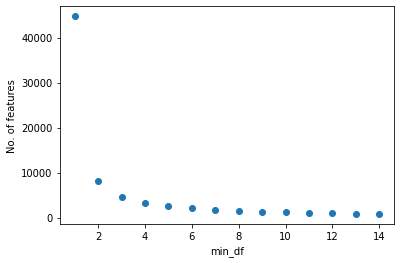

In [44]:
data = []
for i in range(1,15):
    cVect= CountVectorizer(min_df=i, binary=True, tokenizer=dummy, preprocessor=dummy, ngram_range = (1,2))
    tFit = cVect.fit_transform(X_train['text'])
    data.append(tFit.shape[1])
    
plt.scatter(list(range(1,15)), data)
plt.xlabel('min_df')
plt.ylabel('No. of features')
plt.show()

We set min_df to 4 using the same logic as the one used for the bag-of-words model.

In [45]:
ngram_train = CountVectorizer(min_df=4, binary=True, tokenizer=dummy, preprocessor=dummy, ngram_range = (1,2))  
X_train_ngram = ngram_train.fit_transform(X_train['text'])

In [67]:
count = 0
n = 0
for key in ngram_train.vocabulary_.keys():
    if ' ' in key:
        count+=1
        if n<10:
            print(key)
            n+=1

potus strategicpatience
strategicpatience strategy
strategy genocide
genocide refugees
refugees idp
idp internally
internally displaced
displaced people
people horror
horror etc


In [ ]:
print("Number of 2-gram words: "+str(count))

In [47]:
print("Number of 1-gram words: "+str(len(ngram_train.vocabulary_.keys()) - count))

Number of 1-gram words: 2382


In [48]:
ngram_dev = CountVectorizer(min_df=4, binary=True, vocabulary=ngram_train.get_feature_names(),tokenizer=dummy, preprocessor=dummy, ngram_range = (1,2))  
X_dev_ngram = ngram_dev.fit_transform(X_dev['text'])

## Logistic Regression: N-Gram

In [49]:
logreg_l2_ngram = LogisticRegression(solver='saga', penalty='l2', max_iter=200)
logreg_l2_ngram.fit(X_train_ngram, y_train)

LogisticRegression(max_iter=200, solver='saga')

### Training

In [50]:
preds_l2_train_ngram = logreg_l2_ngram.predict(X_train_ngram)
f1_l2_train_ngram = f1_score(y_train, preds_l2_train_ngram)
print(f1_l2_train_ngram)

0.8864942528735632


### Dev

In [51]:
preds_l2_dev_ngram = logreg_l2_ngram.predict(X_dev_ngram)
f1_l2_dev_ngram = f1_score(y_dev, preds_l2_dev_ngram)
print(f1_l2_dev_ngram)

0.7430278884462151


## Bernoulli Naive Bayes': N-Gram

In [52]:
n = X_train_ngram.shape[0]
d = X_train_ngram.shape[1]
K = 2
alpha = 1

psis = np.zeros([K,d])
phis = np.zeros([K])

for k in range(K):
    X_k = X_train_ngram[y_train == k]
    sum_rows = []
    for i in range(d):
        if i>=X_k.shape[0]:
            sum_rows.append(0)
        else:
            sum_rows.append((np.sum(X_k[i])+ alpha) / (X_k.shape[0]+2*alpha))
    psis[k] = sum_rows
    phis[k] = X_k.shape[0] / float(n) 
    
print(psis)

[[0.00138026 0.00069013 0.00138026 ... 0.         0.         0.        ]
 [0.00362647 0.0099728  0.00226655 ... 0.         0.         0.        ]]


In [53]:
train_ngram_idx, train_ngram_logpyx=nb_predictions(X_train_ngram.toarray(), psis, phis)
print(train_ngram_idx[:10])

[0 0 1 0 0 0 0 0 0 0]


In [54]:
f1_bayes_train_ngram = f1_score(y_train, train_idx)
print(f1_bayes_train_ngram)

0.5359342915811088


In [55]:
dev_ngram_idx, dev_ngram_logpyx=nb_predictions(X_dev_ngram.toarray(), psis, phis)
print(dev_ngram_idx[:10])

[0 0 0 0 0 0 1 0 0 0]


In [56]:
f1_bayes_dev_ngram = f1_score(y_dev, dev_ngram_idx)
print(f1_bayes_dev_ngram)

0.18631732168850074


# Final run

## The best performing model in our experiments has been the N-Gram model with L2 regularized Logistic Regression. Hence we decide to use this model, train it on the whole training set, and then run it on the test set to submit to Kaggle.

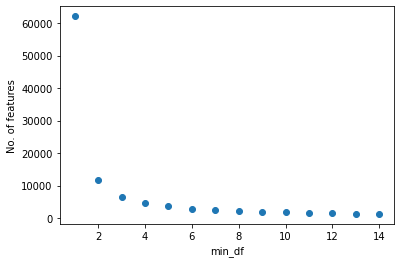

In [57]:
data = []
for i in range(1,15):
    cVect= CountVectorizer(min_df=i, binary=True, tokenizer=dummy, preprocessor=dummy, ngram_range = (1,2))
    tFit = cVect.fit_transform(X['text'])
    data.append(tFit.shape[1])
    
plt.scatter(list(range(1,15)), data)
plt.xlabel('min_df')
plt.ylabel('No. of features')
plt.show()

In [58]:
ngram_X = CountVectorizer(min_df=4, binary=True, tokenizer=dummy, preprocessor=dummy, ngram_range = (1,2))  
X_ngram_vect = ngram_X.fit_transform(X['text'])

In [59]:
ngram_test = CountVectorizer(min_df=4, binary=True, vocabulary=ngram_X.get_feature_names(),tokenizer=dummy, preprocessor=dummy, ngram_range = (1,2))  
test_ngram_vect = ngram_test.fit_transform(t['text'])

In [60]:
logreg_l2_ngram_X = LogisticRegression(solver='saga', penalty='l2', max_iter=200)
logreg_l2_ngram_X.fit(X_ngram_vect, y)

LogisticRegression(max_iter=200, solver='saga')

In [61]:
preds_l2_X_ngram = logreg_l2_ngram_X.predict(X_ngram_vect)
f1_l2_X_ngram = f1_score(y, preds_l2_X_ngram)
print(f1_l2_X_ngram)

0.8825819007460266


In [62]:
preds_l2_test_ngram = logreg_l2_ngram_X.predict(test_ngram_vect)

In [63]:
final_preds = pd.DataFrame()
final_preds['id'] = t['id']
final_preds['target'] = preds_l2_test_ngram

In [64]:
#final_preds.to_csv('sub.csv', index=False)